# Meetup Community Analysis

This notebook analyses the results of applying OSLOM community finding to the Dublin meetup network.

In [1]:
import community
import operator, ast, re
from collections import defaultdict
import networkx as nx
import pandas as pd
pd.set_option('precision', 3)
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pylab as plot
%matplotlib inline
# customise Matplotlib plots
font_size = 14
params = {'legend.fontsize': font_size, 'legend.handlelength': 2, 'font.size' : font_size, 'axes.titlesize' : font_size, 'ytick.labelsize' : font_size }
plot.rcParams.update(params)

File paths and settings:

In [2]:
# input files
network_path = "data/meetup-normalised-comembership.edges"
metadata_path = "data/meetup-metadata.csv"
community_path = "results/oslom-meetup.comm"
stopword_path = "stopwords.txt"
# output files
out_path = "results/meetup-analysis-overall.xlsx"
# settings
min_community_size = 5
top_terms = 10
top_categories = 3
top_nodes = 5

### Data Input & Parsing

Read community memberships from a while with a list of node identifiers (assumed to be integers), one community per line. Ignore communities below a specific size.

In [3]:
communities = community.read_communities( community_path, min_community_size )

Found 26 communities, after filtering 6 communities of size < 5


In [4]:
nodes = set()
for comm in communities:
    for node in comm:
        nodes.add(node)
print("Communities cover %d unique nodes" % len(nodes) )

Communities cover 1466 unique nodes


Read the meetup metadata:

In [5]:
df_meta = pd.read_csv( metadata_path, sep = "|", index_col="Id", converters={7:ast.literal_eval} )
print("Read metadata for %d meetups" % len(df_meta) )
df_meta.head()

Read metadata for 1482 meetups


,meetup_id,name,member_count,join_mode,description,created,categories
Id,,,,,,,
1,370896,New and Not So New In Dublin,21149,open,Welcome to New and Not So New Dublin s largest...,2006-11-22,[Socializing]
2,8749202,20-35 Somethin's,5575,open,20 35 somethings is a group for people in thei...,2013-06-02,[Socializing]
3,19190729,Machine Learning Dublin,4422,open,This is a last Monday of the month meetup grou...,2015-12-07,[Tech]
4,28444095,Data Science Festival - Dublin,688,open,The focus of this Meetup group is to provide f...,2018-05-10,[Tech]
5,11686062,"Events, Drinks and Dancing in Dublin",16582,open,This is not a dating site but accidents do hap...,2014-01-02,[Socializing]


### Basic Characterisation of Communities

In [6]:
rows = []
for i, comm in enumerate(communities):
    rows.append( { "Community" : i+1, "Size" : len(comm) } )
df_comm = pd.DataFrame( rows ).set_index("Community")
df_comm.sort_values("Size",ascending=False).head(10)

,Size
Community,
5,216
4,148
7,137
17,118
14,84
22,80
3,78
25,77
10,71


Generate histogram of community sizes

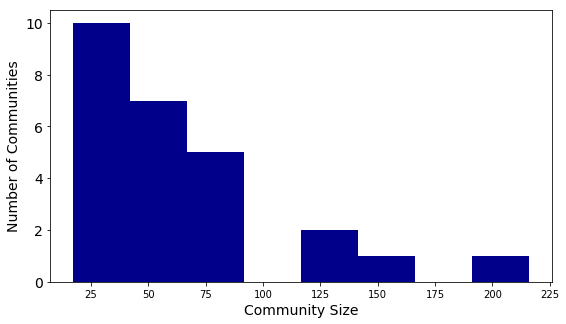

In [7]:
p = df_comm["Size"].hist(figsize=(9,5), color="darkblue", grid=False, bins=8)
p.set_ylabel("Number of Communities", fontsize=font_size);
p.set_xlabel("Community Size", fontsize=font_size);

Look at number of members in the meetups in each community:

In [8]:
mean_members, median_members = {}, {}
for i, comm in enumerate(communities):
    comm_member_counts = np.array( [ df_meta.loc[node]["member_count"] for node in comm ] )
    mean_members[i+1] = int(comm_member_counts.mean())
    median_members[i+1] = int(np.median(comm_member_counts))
# add to the community data frame
df_comm["Mean Members"] = pd.Series(mean_members)
df_comm["Median Members"] = pd.Series(median_members)

In [9]:
df_comm.sort_values("Mean Members",ascending=False).head(10)

,Size,Mean Members,Median Members
Community,,,
5,216,2079,1067
18,63,1272,530
9,30,1257,599
1,30,978,559
7,137,915,652
3,78,890,452
16,53,827,494
12,41,671,313
4,148,632,331


Create the binary row-community assignment DataFrame:

In [10]:
C = np.zeros((len(df_meta),len(communities)), dtype=int)
for i, comm in enumerate(communities):
    for node in comm:
        C[node-1,i] = 1

In [11]:
index = np.arange(1, len(df_meta)+1, dtype=int)
columns = [ "C%02d" % (i+1) for i in range(len(communities)) ]
df_assign = pd.DataFrame(C, index=index, columns=columns)
df_assign.head()

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


### Labelling Communities with Text

Load stopwords to filter from the text

In [12]:
stopwords = set()
for line in open(stopword_path,"r").readlines():
    stopwords.add( line.strip().lower() )
print("Read %d stopwords" % len(stopwords) )

Read 388 stopwords


Code for text pre-processing 

In [13]:
token_pattern = re.compile(r"\b\w\w+\b", re.U)
def custom_tokenizer( s, min_term_length = 2 ):
    return [x for x in token_pattern.findall(s) if (len(x) >= min_term_length and (not x.isnumeric() ) ) ]

In [14]:
def preprocess( docs ):
    tfidf = TfidfVectorizer(stop_words=stopwords, lowercase=True, 
                            tokenizer=custom_tokenizer, strip_accents="unicode", 
                            use_idf=True, norm="l2", min_df = 3, ngram_range=(1,1)) 
    X = tfidf.fit_transform(docs)
    terms = []
    # store the vocabulary map
    v = tfidf.vocabulary_
    for i in range(len(v)):
        terms.append("")
    for term in v.keys():
        terms[ v[term] ] = term
    return (X,terms)

Create bag-of-words from the meetup names

In [15]:
name_documents = list(df_meta["name"])

In [16]:
(X,name_terms) = preprocess( name_documents )
num_name_docs, num_name_terms = X.shape[0], X.shape[1]
print( "Meetup name document-term matrix: %d documents, %d terms" % (num_name_docs, num_name_terms) )

Meetup name document-term matrix: 1482 documents, 312 terms


Create bag-of-words from the meetup descriptions

In [17]:
df_meta[pd.isnull(df_meta).any(axis=1)]

,meetup_id,name,member_count,join_mode,description,created,categories
Id,,,,,,,


In [18]:
desc_documents = list(df_meta["description"])

In [19]:
(D,desc_terms) = preprocess( desc_documents )
num_desc_docs, num_desc_terms = D.shape[0], D.shape[1]
print( "Meetup description document-term matrix: %d documents, %d terms" % (num_desc_docs, num_desc_terms) )

Meetup description document-term matrix: 1482 documents, 3945 terms


For each community, identify the top terms from the names and descriptions of the meetups assigned to that community:

In [20]:
name_labels, desc_labels = {}, {}
for i, comm in enumerate(communities):
    # Compute the centroid vectors for both BoW models
    name_centroid = np.zeros( num_name_terms )
    desc_centroid = np.zeros( num_desc_terms )
    for node in comm:
        row = node - 1
        name_centroid += X[row,:]
        desc_centroid += D[row,:]
    name_centroid /= len(comm)
    desc_centroid /= len(comm)
    # Rank the name terms
    top_name_indices = np.argsort( name_centroid ).tolist()[0][::-1]
    top_name_terms = [ name_terms[i] for i in top_name_indices[0:top_terms] ]
    name_labels[i+1] = ", ".join( top_name_terms )
    # Rank the description terms
    top_desc_indices = np.argsort( desc_centroid ).tolist()[0][::-1]
    top_desc_terms = [ desc_terms[i] for i in top_desc_indices[0:top_terms] ]    
    desc_labels[i+1] = ", ".join( top_desc_terms )    
    
df_comm["Top %d Name Terms" % top_terms ] = pd.Series(name_labels)
df_comm["Top %d Description Terms" % top_terms ] = pd.Series(desc_labels)

In [21]:
df_comm.head()

,Size,Mean Members,Median Members,Top 10 Name Terms,Top 10 Description Terms
Community,,,,,
1,30,978,559,"lgbt, gay, photography, social, food, rock, ac...","gay, lgbt, geeks, chat, social, different, dri..."
2,28,327,224,"blockchain, crypto, tallaght, development, tec...","blockchain, crypto, bitcoin, ethereum, technol..."
3,78,890,452,"startup, entrepreneurs, digital, lean, busines...","business, entrepreneurs, marketing, startup, n..."
4,148,632,331,"meditation, yoga, healing, spiritual, heart, s...","healing, life, meditation, experience, self, e..."
5,216,2079,1067,"hiking, international, wicklow, friends, yoga,...","fun, members, friends, time, hikes, free, soci..."


### Labelling Communities by Categories

Calculate the overall category counts:

In [22]:
global_cat_counts = defaultdict(int)
for cat_list in df_meta["categories"]:
    for cat in cat_list:
        global_cat_counts[cat] += 1

In [23]:
s_global_cat_counts = pd.Series(global_cat_counts)
s_global_cat_counts.sort_values(ascending=False).head(10)

Tech                      338
Health & Wellbeing        229
Support                   229
Career & Business         148
Religion & Beliefs        108
New Age & Spirituality    108
Paranormal                108
Fitness                    99
Sports & Recreation        99
Socializing                68
dtype: int64

Get top precision, recall and F1 for community-category pairs

In [24]:
def select_dict_top( d, top ):
    sx = sorted(d.items(), key=operator.itemgetter(1), reverse=True)
    values = []
    for i in range( min(3,len(sx)) ):
        values.append( "%s (%.2f)" % ( sx[i][0], sx[i][1] ) )
    return ", ".join( values )

In [25]:
comm_precision, comm_recall, comm_f1 = {}, {}, {}
for i, comm in enumerate(communities):
    comm_cats = defaultdict(int)
    # get the category counts for this community
    for node in comm:
        for cat in df_meta.loc[node]["categories"]:
            comm_cats[cat] += 1
    # calculate precision, recall and f1
    precision, recall, f1 = {}, {}, {}
    for cat in comm_cats:
        precision[cat] = float(comm_cats[cat]) / len(comm)
        recall[cat] = float(comm_cats[cat]) / global_cat_counts[cat]
        f1[cat] = 2*((precision[cat]*recall[cat])/(precision[cat]+recall[cat]))
    # get the top elements
    comm_precision[i+1] = select_dict_top( precision, top_categories )
    comm_recall[i+1] = select_dict_top( recall, top_categories )
    comm_f1[i+1] = select_dict_top( f1, top_categories )

In [26]:
# add to the community data frame
df_comm["Top %d Category Precision" % top_categories] = pd.Series(comm_precision)
df_comm["Top %d Category Recall" % top_categories] = pd.Series(comm_recall)
df_comm["Top %d Category F1" % top_categories] = pd.Series(comm_f1)

In [27]:
df_comm.head()

,Size,Mean Members,Median Members,Top 10 Name Terms,Top 10 Description Terms,Top 3 Category Precision,Top 3 Category Recall,Top 3 Category F1
Community,,,,,,,,
1,30,978,559,"lgbt, gay, photography, social, food, rock, ac...","gay, lgbt, geeks, chat, social, different, dri...","LGBT (0.47), Photography (0.10), Fitness (0.07)","LGBT (1.00), Photography (0.30), Book Clubs (0...","LGBT (0.64), Photography (0.15), Music (0.05)"
2,28,327,224,"blockchain, crypto, tallaght, development, tec...","blockchain, crypto, bitcoin, ethereum, technol...","Tech (0.93), Career & Business (0.07)","Tech (0.08), Career & Business (0.01)","Tech (0.14), Career & Business (0.02)"
3,78,890,452,"startup, entrepreneurs, digital, lean, busines...","business, entrepreneurs, marketing, startup, n...","Career & Business (0.54), Tech (0.37), Educati...","Career & Business (0.28), Education & Learning...","Career & Business (0.37), Tech (0.14), Educati..."
4,148,632,331,"meditation, yoga, healing, spiritual, heart, s...","healing, life, meditation, experience, self, e...","Health & Wellbeing (0.51), Support (0.51), New...","New Age & Spirituality (0.45), Paranormal (0.4...","Health & Wellbeing (0.40), Support (0.40), New..."
5,216,2079,1067,"hiking, international, wicklow, friends, yoga,...","fun, members, friends, time, hikes, free, soci...","Cars & Motorcycles (0.16), Outdoors & Adventur...","Photography (0.60), Parents & Family (0.60), C...","Cars & Motorcycles (0.25), Outdoors & Adventur..."


### Analysis of Community Overlap

Count communities per node

In [28]:
node_community_counts = defaultdict(int)
for comm in communities:
    for node in comm:
        node_community_counts[node] += 1
s_community_counts = pd.Series( node_community_counts, dtype=int )
print("Mean communities per node = %.2f" % s_community_counts.mean() )

Mean communities per node = 1.15


How many nodes in more than one community?

In [29]:
len( s_community_counts[s_community_counts > 1] )

197

In [30]:
value_counts = s_community_counts.value_counts()
value_counts

1    1269
2     176
3      20
4       1
dtype: int64

In [31]:
per_counts = 100 * ( value_counts/len(nodes) )
per_counts

1    86.562
2    12.005
3     1.364
4     0.068
dtype: float64

Find the most overlapping nodes:

In [32]:
df_meta["Communities"] = s_community_counts
df_meta.sort_values("Communities",ascending=False).head(25)

,meetup_id,name,member_count,join_mode,description,created,categories,Communities
Id,,,,,,,,
1346,19140096,Headless Awareness Dublin,70,open,This group is about waking up to a new level o...,2015-11-20,"[New Age & Spirituality, Paranormal, Religion ...",4.0
311,18377859,Dublin Yoga for Everyone,2863,open,Yoga is a process and a journey that can help ...,2015-01-25,"[Health & Wellbeing, Support]",3.0
609,18802268,GAELCON 2017,60,open,The best 4 days in Irish gaming We ll have a m...,2015-08-04,"[Games, Sci-Fi & Fantasy]",3.0
876,24114196,Yoga with Miriam,30,open,This is yoga for everybody all shapes all size...,2017-05-29,"[Health & Wellbeing, Support]",3.0
341,18709373,Dublin Foosball,497,open,Do you like play foosball chat listen to some ...,2015-06-30,"[Games, Sci-Fi & Fantasy]",3.0
193,21985109,Dublin Nightlife,2361,open,The whole purpose of Dublin Nightlife is Based...,2017-01-19,[Socializing],3.0
533,27058744,Acting for Camera Course,360,open,IF YOU ARE INTERESTED IN ACTING FOR SCREEN THI...,2018-01-05,[Movies & Film],3.0
342,18305854,How to use your Camera Photography Meetup,5267,open,Hi can I give you a warm welcome to this group...,2015-01-06,[Photography],3.0
317,26251755,Electronic Music & Food Sessions,1104,open,Let s make our love for Electronic music i e T...,2017-10-13,[Music],3.0


Plot overal communities per node

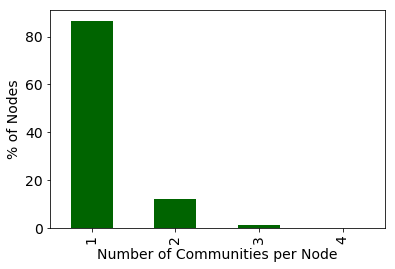

In [33]:
p = per_counts.plot(kind="bar", fontsize=font_size, figsize=(6,4), color="darkgreen")
p.set_xlabel("Number of Communities per Node", fontsize=font_size);
p.set_ylabel("% of Nodes", fontsize=font_size);

Find the level of overlap in each community

In [34]:
rows = []
for i, comm in enumerate(communities):
    overlaps = []
    for node in comm:
        overlaps.append( node_community_counts[node] )
    unique_nodes = overlaps.count( 1 )/len(comm)
    overlaps = np.array(overlaps)
    rows.append( { "Community" : i+1, 
                  "% Unique Nodes" : round(100.0*unique_nodes,2),
                  "Mean Node Overlap" : round(overlaps.mean(),2), 
                  "Median Node Overlap": int(np.median(overlaps)) } )
df_overlap = pd.DataFrame( rows ).set_index("Community")
df_overlap.head()

,% Unique Nodes,Mean Node Overlap,Median Node Overlap
Community,,,
1,53.33,1.70,1
2,60.71,1.43,1
3,65.38,1.35,1
4,87.84,1.14,1
5,83.33,1.19,1


In [35]:
df_comm = df_comm.join(df_overlap)
df_comm.head()

,Size,Mean Members,Median Members,Top 10 Name Terms,Top 10 Description Terms,Top 3 Category Precision,Top 3 Category Recall,Top 3 Category F1,% Unique Nodes,Mean Node Overlap,Median Node Overlap
Community,,,,,,,,,,,
1,30,978,559,"lgbt, gay, photography, social, food, rock, ac...","gay, lgbt, geeks, chat, social, different, dri...","LGBT (0.47), Photography (0.10), Fitness (0.07)","LGBT (1.00), Photography (0.30), Book Clubs (0...","LGBT (0.64), Photography (0.15), Music (0.05)",53.33,1.70,1
2,28,327,224,"blockchain, crypto, tallaght, development, tec...","blockchain, crypto, bitcoin, ethereum, technol...","Tech (0.93), Career & Business (0.07)","Tech (0.08), Career & Business (0.01)","Tech (0.14), Career & Business (0.02)",60.71,1.43,1
3,78,890,452,"startup, entrepreneurs, digital, lean, busines...","business, entrepreneurs, marketing, startup, n...","Career & Business (0.54), Tech (0.37), Educati...","Career & Business (0.28), Education & Learning...","Career & Business (0.37), Tech (0.14), Educati...",65.38,1.35,1
4,148,632,331,"meditation, yoga, healing, spiritual, heart, s...","healing, life, meditation, experience, self, e...","Health & Wellbeing (0.51), Support (0.51), New...","New Age & Spirituality (0.45), Paranormal (0.4...","Health & Wellbeing (0.40), Support (0.40), New...",87.84,1.14,1
5,216,2079,1067,"hiking, international, wicklow, friends, yoga,...","fun, members, friends, time, hikes, free, soci...","Cars & Motorcycles (0.16), Outdoors & Adventur...","Photography (0.60), Parents & Family (0.60), C...","Cars & Motorcycles (0.25), Outdoors & Adventur...",83.33,1.19,1


### Node-Community Centrality Analysis

Load the network

In [36]:
def read_weighted_edgelist( in_path ):
    g = nx.Graph()
    fin = open(in_path,"r")
    for line in fin.readlines():
        parts = line.strip().split(" ")
        node1, node2 = int(parts[0]), int(parts[1])
        if node1 != node2:
            g.add_edge( node1, node2, weight=float(parts[2]) )
    fin.close()
    return g

In [37]:
g = read_weighted_edgelist(network_path)
print( "Network has %d nodes, %d edges" % ( g.number_of_nodes(), g.number_of_edges() ) )

Network has 1481 nodes, 708163 edges


Calculate the weighted degree centrality for the subgraph induced by each community.

In [38]:
def calc_node_community_centrality(g, comm):
    sg = g.subgraph( comm )
    rows = []    
    centrality_scores = dict(nx.degree(sg, weight="weight"))
    for node in centrality_scores:
        rows.append( { "Id" : node, "Weighted Degree" : centrality_scores[node], 
                    "Meetup Name" : df_meta["name"].loc[node] } )
    return pd.DataFrame(rows).set_index("Id")

Get most central nodes for each community:

In [39]:
cc_dfs = {}
community_top_nodes = {}
for i, comm in enumerate(communities):
    df_c = calc_node_community_centrality( g, comm )
    df_c = df_c.sort_values("Weighted Degree", ascending=False)
    values = []
    for name in df_c["Meetup Name"].head( min(top_nodes,len(comm)) ):
        values.append( name.replace(","," ") )
    community_top_nodes[i+1] = ", ".join( values )
    cc_dfs[i+1] = df_c
df_comm["Top %d Nodes" % top_nodes ] = pd.Series(community_top_nodes)

In [40]:
df_comm.head()

,Size,Mean Members,Median Members,Top 10 Name Terms,Top 10 Description Terms,Top 3 Category Precision,Top 3 Category Recall,Top 3 Category F1,% Unique Nodes,Mean Node Overlap,Median Node Overlap,Top 5 Nodes
Community,,,,,,,,,,,,
1,30,978,559,"lgbt, gay, photography, social, food, rock, ac...","gay, lgbt, geeks, chat, social, different, dri...","LGBT (0.47), Photography (0.10), Fitness (0.07)","LGBT (1.00), Photography (0.30), Book Clubs (0...","LGBT (0.64), Photography (0.15), Music (0.05)",53.33,1.70,1,"Dublin LGBT Social Meetup, GayDublin, D08 LGBT..."
2,28,327,224,"blockchain, crypto, tallaght, development, tec...","blockchain, crypto, bitcoin, ethereum, technol...","Tech (0.93), Career & Business (0.07)","Tech (0.08), Career & Business (0.01)","Tech (0.14), Career & Business (0.02)",60.71,1.43,1,"Crypto Ireland, Ethereum Ireland, Dublin Ether..."
3,78,890,452,"startup, entrepreneurs, digital, lean, busines...","business, entrepreneurs, marketing, startup, n...","Career & Business (0.54), Tech (0.37), Educati...","Career & Business (0.28), Education & Learning...","Career & Business (0.37), Tech (0.14), Educati...",65.38,1.35,1,"Startup Grind Dublin, Dublin Startup Founder 1..."
4,148,632,331,"meditation, yoga, healing, spiritual, heart, s...","healing, life, meditation, experience, self, e...","Health & Wellbeing (0.51), Support (0.51), New...","New Age & Spirituality (0.45), Paranormal (0.4...","Health & Wellbeing (0.40), Support (0.40), New...",87.84,1.14,1,"Dublin Meditation Meetup, Dublin Self-Empowerm..."
5,216,2079,1067,"hiking, international, wicklow, friends, yoga,...","fun, members, friends, time, hikes, free, soci...","Cars & Motorcycles (0.16), Outdoors & Adventur...","Photography (0.60), Parents & Family (0.60), C...","Cars & Motorcycles (0.25), Outdoors & Adventur...",83.33,1.19,1,"Kick Ass Adventures, Awesome Daytrips, Live Mu..."


Export everything to Excel

In [41]:
print("Writing %s" % out_path)
writer = pd.ExcelWriter(out_path)
df_meta.to_excel(writer, "Nodes")
df_comm.to_excel(writer, "Communities")
df_assign.to_excel(writer, "Assignments")
# add the community memberships
for comm_id in range( 1, len(communities)+1 ):
    cc_dfs[comm_id].to_excel(writer, "Community %02d" % comm_id )
writer.save()

Writing results/meetup-analysis-overall.xlsx
